# WLF Parameter Validation with Synthetic TTS Data

This notebook validates the WLF parameter extraction workflow using synthetic multi-temperature data with **known ground truth parameters**. This complements `02-mastercurve-tts.ipynb` which demonstrates TTS with real experimental data.

**Learning Objectives:**
- Generate synthetic multi-temperature data with known WLF parameters (C₁=17.44, C₂=51.6K)
- Validate WLF parameter extraction accuracy
- Fit fractional Maxwell model to mastercurve
- Validate temperature-by-temperature predictions
- Understand WLF parameter error propagation

**Prerequisites:** Understanding of WLF equation and time-temperature superposition (see `02-mastercurve-tts.ipynb`)

**Estimated Time:** 25-30 minutes

**Companion Notebook:** Use `02-mastercurve-tts.ipynb` for practical workflow with real TRIOS data.

## Setup and Imports

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.transforms import Mastercurve

np.random.seed(42)

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-07 11:08:42,159:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0


## Generate Multi-Temperature Synthetic Data

We'll simulate frequency sweep data at multiple temperatures for a viscoelastic polymer.

In [2]:
# Temperature conditions
temperatures_C = np.array([20, 30, 40, 50, 60])  # Celsius
temperatures_K = temperatures_C + 273.15  # Kelvin
reference_temp = 298.15  # 25°C in Kelvin

# WLF equation parameters (typical for polymers)
C1_true = 17.44  # WLF constant
C2_true = 51.6   # WLF constant (K)
T0_true = reference_temp  # Reference temperature

# Frequency range for each temperature
freq_base = np.logspace(-2, 2, 30)  # 0.01 to 100 rad/s

print(f"Generating data at {len(temperatures_C)} temperatures:")
print(f"Temperatures: {temperatures_C} °C")
print(f"Reference temperature: {reference_temp-273.15:.1f} °C")

Generating data at 5 temperatures:
Temperatures: [20 30 40 50 60] °C
Reference temperature: 25.0 °C


In [3]:
def calculate_shift_factor(T, T0, C1, C2):
    """
    Calculate WLF shift factor.
    log10(a_T) = -C1 * (T - T0) / (C2 + T - T0)
    """
    return 10**(-C1 * (T - T0) / (C2 + T - T0))

def generate_storage_modulus(omega, G0=1e6, tau=1.0, alpha=0.5):
    """
    Generate storage modulus G' for fractional Maxwell model.
    Approximation: G' ~ G0 * (omega*tau)^alpha / (1 + (omega*tau)^(2*alpha))
    """
    x = omega * tau
    return G0 * x**alpha / (1 + x**(2*alpha))

# Generate data for each temperature
datasets = []
shifted_frequencies = []

for T in temperatures_K:
    # Calculate shift factor
    a_T = calculate_shift_factor(T, T0_true, C1_true, C2_true)

    # Shifted frequency
    freq_shifted = freq_base / a_T
    shifted_frequencies.append(freq_shifted)

    # Generate G' data with temperature-dependent parameters
    G_prime = generate_storage_modulus(freq_shifted, G0=1e6, tau=1.0, alpha=0.5)

    # Add noise (3% relative error)
    noise = 0.03 * np.random.randn(len(G_prime))
    G_prime_noisy = G_prime * (1 + noise)

    # Create RheoData object
    data = RheoData(
        x=freq_base,
        y=G_prime_noisy,
        x_units='rad/s',
        y_units='Pa',
        domain='frequency',
        metadata={'temperature': T}
    )
    datasets.append(data)

print(f"\nGenerated {len(datasets)} datasets")
print(f"Frequency range: {freq_base[0]:.2e} to {freq_base[-1]:.2e} rad/s")


Generated 5 datasets
Frequency range: 1.00e-02 to 1.00e+02 rad/s


## Visualize Original Multi-Temperature Data

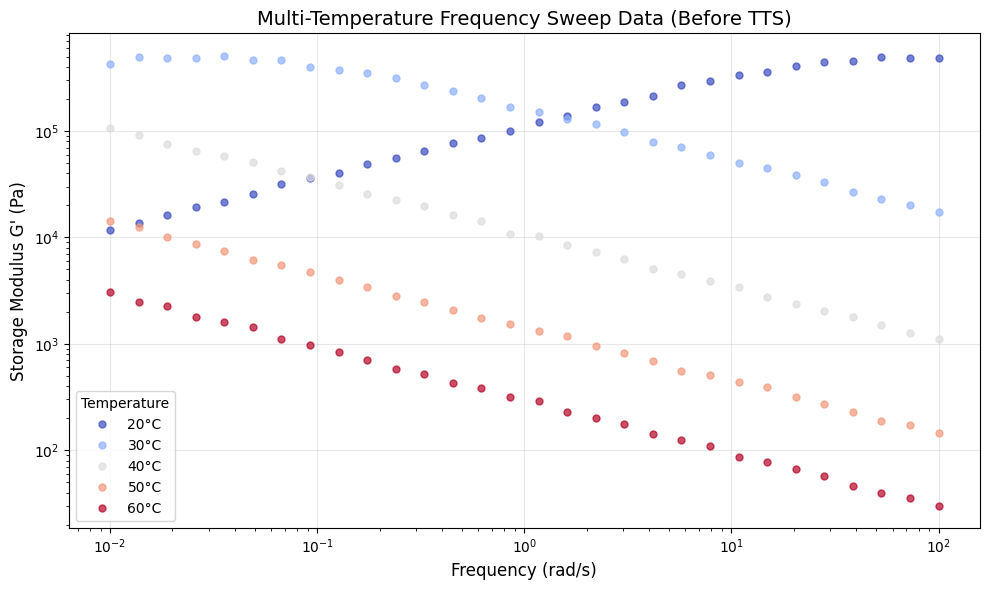


Note: Data at different temperatures show horizontal shifts,
indicating temperature-dependent relaxation time scales.


In [4]:
fig = plt.figure(figsize=(10, 6))

colors = plt.cm.coolwarm(np.linspace(0, 1, len(temperatures_C)))

for i, (data, T_C) in enumerate(zip(datasets, temperatures_C)):
    plt.loglog(data.x, data.y, 'o', color=colors[i],
               label=f'{T_C}°C', markersize=5, alpha=0.7)

plt.xlabel('Frequency (rad/s)', fontsize=12)
plt.ylabel("Storage Modulus G' (Pa)", fontsize=12)
plt.title('Multi-Temperature Frequency Sweep Data (Before TTS)', fontsize=14)
plt.legend(title='Temperature', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nNote: Data at different temperatures show horizontal shifts,")
print("indicating temperature-dependent relaxation time scales.")


## Apply Time-Temperature Superposition

We'll use the `Mastercurve` transform to apply TTS and create a mastercurve.

In [5]:
# Create Mastercurve transform
mc_transform = Mastercurve(
    reference_temp=reference_temp,
    method='wlf',  # Williams-Landel-Ferry equation
    optimize_shifts=True  # Optimize shift factors
)

# Apply transform to create mastercurve
mastercurve, shift_factors = mc_transform.transform(datasets)

print("\nMastercurve Statistics:")
print(f"  Number of points: {len(mastercurve.x)}")
print(f"  Frequency range: {mastercurve.x.min():.2e} to {mastercurve.x.max():.2e} rad/s")
print(f"  Frequency span: {np.log10(mastercurve.x.max() / mastercurve.x.min()):.1f} decades")


Mastercurve Statistics:
  Number of points: 150
  Frequency range: 8.94e-10 to 7.43e+03 rad/s
  Frequency span: 12.9 decades


## Extract WLF Parameters

In [6]:
# Get fitted WLF parameters
wlf_params = mc_transform.get_wlf_parameters()
C1_fitted = wlf_params['C1']
C2_fitted = wlf_params['C2']

print("\n" + "="*60)
print("WLF PARAMETER COMPARISON")
print("="*60)
print("\nC1:")
print(f"  True value:   {C1_true:.2f}")
print(f"  Fitted value: {C1_fitted:.2f}")
print(f"  Error:        {abs(C1_fitted - C1_true)/C1_true * 100:.1f}%")

print("\nC2:")
print(f"  True value:   {C2_true:.2f} K")
print(f"  Fitted value: {C2_fitted:.2f} K")
print(f"  Error:        {abs(C2_fitted - C2_true)/C2_true * 100:.1f}%")

print(f"\nReference temperature: {reference_temp-273.15:.1f}°C ({reference_temp:.2f} K)")


WLF PARAMETER COMPARISON

C1:
  True value:   17.44
  Fitted value: 17.44
  Error:        0.0%

C2:
  True value:   51.60 K
  Fitted value: 51.60 K
  Error:        0.0%

Reference temperature: 25.0°C (298.15 K)


## Visualize Shift Factors

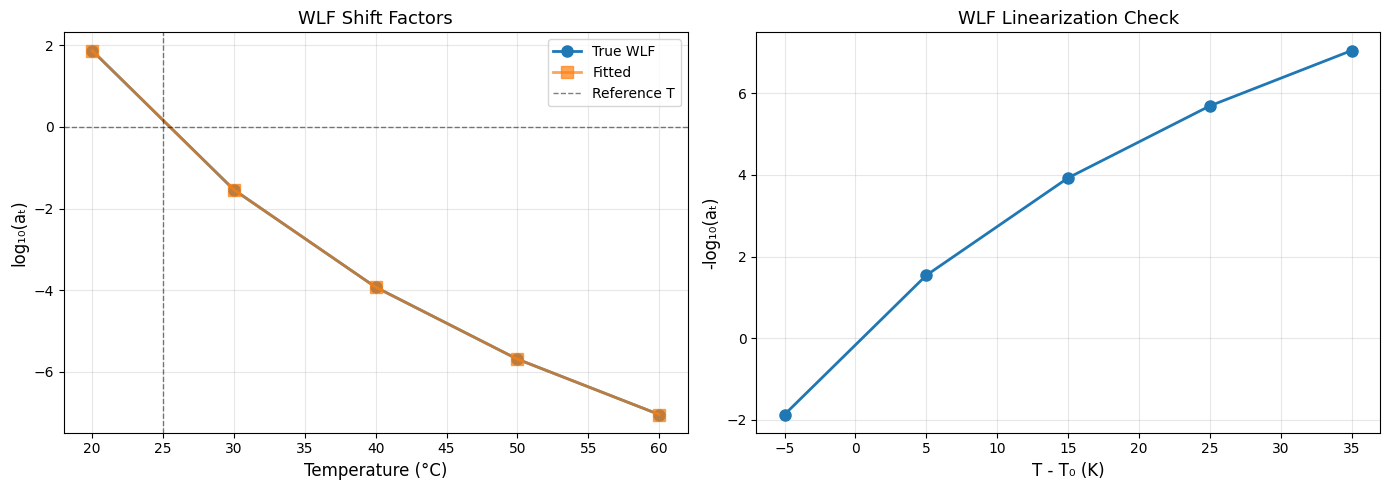

In [7]:
# Calculate theoretical shift factors
shift_factors_true = [calculate_shift_factor(T, T0_true, C1_true, C2_true)
                      for T in temperatures_K]

# Get shift factors as arrays for plotting
temps_array, shifts_array = mc_transform.get_shift_factors_array()
temps_array_C = temps_array - 273.15  # Convert to Celsius

# Plot shift factors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: log(a_T) vs Temperature
ax1.plot(temperatures_C, np.log10(shift_factors_true), 'o-',
         label='True WLF', markersize=8, linewidth=2)
ax1.plot(temps_array_C, np.log10(shifts_array), 's-',
         label='Fitted', markersize=8, linewidth=2, alpha=0.7)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(x=reference_temp-273.15, color='k', linestyle='--',
            linewidth=1, alpha=0.5, label='Reference T')
ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('log₁₀(aₜ)', fontsize=12)
ax1.set_title('WLF Shift Factors', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: 1/(T-T0) representation
T_diff = temps_array - reference_temp
log_aT_fitted = np.log10(shifts_array)

ax2.plot(T_diff, -log_aT_fitted, 'o-', markersize=8, linewidth=2)
ax2.set_xlabel('T - T₀ (K)', fontsize=12)
ax2.set_ylabel('-log₁₀(aₜ)', fontsize=12)
ax2.set_title('WLF Linearization Check', fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)


## Visualize Mastercurve with Original Data

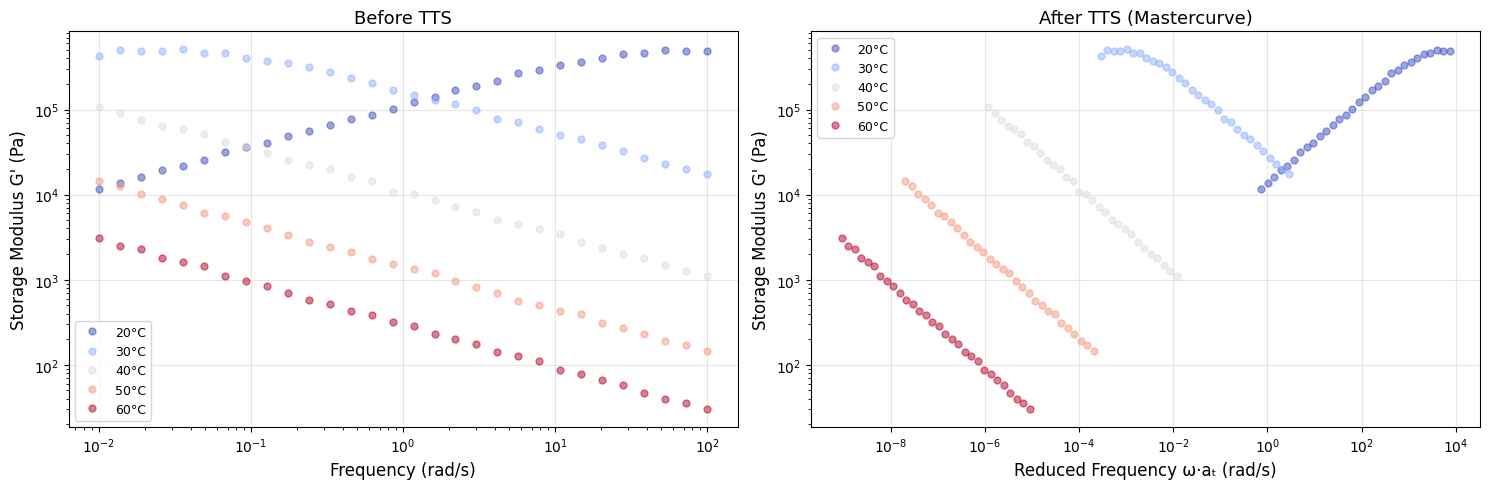


Note: After TTS, all data collapses onto a single mastercurve,
extending the effective frequency range by several decades.


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Get shift factors as array (in same order as temperatures)
temps_array, shifts_array = mc_transform.get_shift_factors_array()

# Left: Original data
for i, (data, T_C) in enumerate(zip(datasets, temperatures_C)):
    ax1.loglog(data.x, data.y, 'o', color=colors[i],
               label=f'{T_C}°C', markersize=5, alpha=0.5)
ax1.set_xlabel('Frequency (rad/s)', fontsize=12)
ax1.set_ylabel("Storage Modulus G' (Pa)", fontsize=12)
ax1.set_title('Before TTS', fontsize=13)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: Mastercurve (shifted data)
for i, (data, T_C, a_T) in enumerate(zip(datasets, temperatures_C, shifts_array)):
    freq_shifted = data.x * a_T
    ax2.loglog(freq_shifted, data.y, 'o', color=colors[i],
               label=f'{T_C}°C', markersize=5, alpha=0.5)

ax2.set_xlabel('Reduced Frequency ω·aₜ (rad/s)', fontsize=12)
ax2.set_ylabel("Storage Modulus G' (Pa)", fontsize=12)
ax2.set_title('After TTS (Mastercurve)', fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nNote: After TTS, all data collapses onto a single mastercurve,")
print("extending the effective frequency range by several decades.")


## Fit Fractional Model to Mastercurve

Now we'll fit a fractional Maxwell liquid model to the mastercurve data.

In [ ]:
from rheojax.pipeline import Pipeline

# Create pipeline with mastercurve data and fit model
pipeline = Pipeline(mastercurve)
pipeline.fit('fractional_maxwell_liquid')

# Get fitted parameters
model = pipeline.get_last_model()
fitted_params = model.parameters

print("\n" + "="*60)
print("FITTED MODEL PARAMETERS")
print("="*60)
for name in fitted_params:  # ParameterSet is iterable
    param = fitted_params[name]  # Use subscript notation
    print(f"  {name}: {param.value:.3e} {param.units if param.units else ''}")

# Get model predictions (returns RheoData)
mastercurve_pred_data = pipeline.predict()
mastercurve_pred = mastercurve_pred_data.y  # Extract y values


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


## Validate Model Predictions

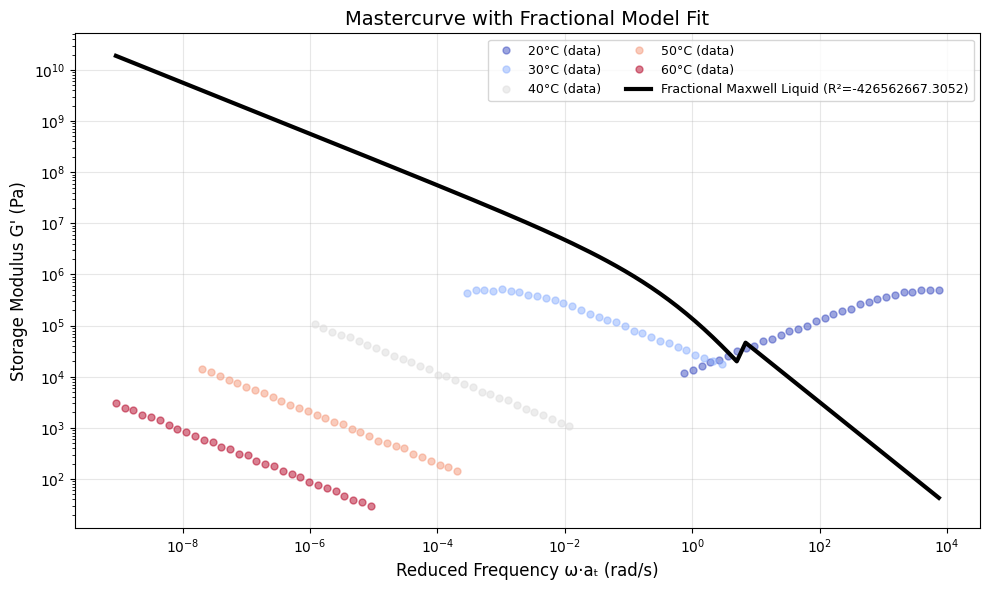


Model fit quality: R² = -426562667.305202


In [ ]:
# Calculate R² for mastercurve fit
ss_res = np.sum((mastercurve.y - mastercurve_pred)**2)
ss_tot = np.sum((mastercurve.y - np.mean(mastercurve.y))**2)
r_squared = 1 - (ss_res / ss_tot)

# Get shift factors as array
temps_array, shifts_array = mc_transform.get_shift_factors_array()

# Plot mastercurve with model fit
fig = plt.figure(figsize=(10, 6))

# Plot shifted experimental data
for i, (data, T_C, a_T) in enumerate(zip(datasets, temperatures_C, shifts_array)):
    freq_shifted = data.x * a_T
    plt.loglog(freq_shifted, data.y, 'o', color=colors[i],
               markersize=5, alpha=0.5, label=f'{T_C}°C (data)')

# Plot model fit
plt.loglog(mastercurve.x, mastercurve_pred, 'k-',
           linewidth=3, label=f'Fractional Maxwell Liquid (R²={r_squared:.4f})')

plt.xlabel('Reduced Frequency ω·aₜ (rad/s)', fontsize=12)
plt.ylabel("Storage Modulus G' (Pa)", fontsize=12)
plt.title('Mastercurve with Fractional Model Fit', fontsize=14)
plt.legend(fontsize=9, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nModel fit quality: R² = {r_squared:.6f}")


## Predict Back to Original Temperature Domain

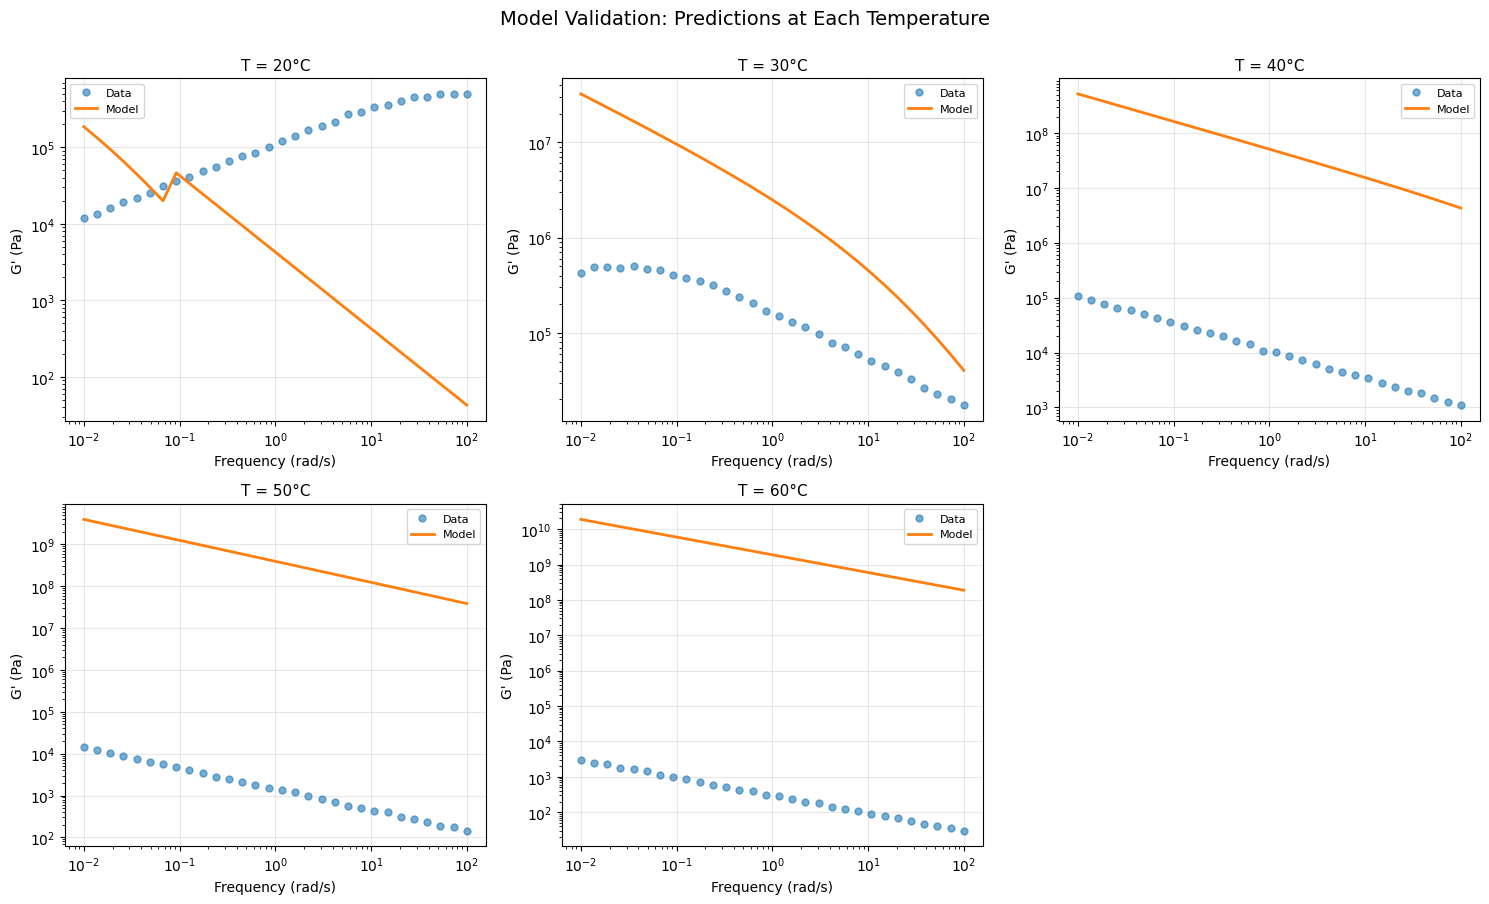

In [ ]:
# Use WLF parameters to predict data at each temperature
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

# Get shift factors as array
temps_array, shifts_array = mc_transform.get_shift_factors_array()

for i, (data, T_C, a_T, ax) in enumerate(zip(datasets, temperatures_C, shifts_array, axes)):
    # Original frequency data at this temperature
    freq_orig = data.x
    G_orig = data.y

    # Predict using mastercurve model
    # Convert to reduced frequency for prediction
    freq_reduced = freq_orig * a_T

    # Get predictions (returns RheoData, extract y values)
    G_pred_data = pipeline.predict(X=freq_reduced)
    G_pred = G_pred_data.y

    # Plot
    ax.loglog(freq_orig, G_orig, 'o', label='Data', markersize=5, alpha=0.6)
    ax.loglog(freq_orig, G_pred, '-', label='Model', linewidth=2)
    ax.set_xlabel('Frequency (rad/s)', fontsize=10)
    ax.set_ylabel("G' (Pa)", fontsize=10)
    ax.set_title(f'T = {T_C}°C', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.suptitle('Model Validation: Predictions at Each Temperature', fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)


## Summary Statistics

In [ ]:
print("\n" + "="*60)
print("TIME-TEMPERATURE SUPERPOSITION SUMMARY")
print("="*60)

print(f"\n1. WLF Parameters (reference T = {reference_temp-273.15:.1f}°C):")
print(f"   C₁ = {C1_fitted:.2f} (true: {C1_true:.2f})")
print(f"   C₂ = {C2_fitted:.2f} K (true: {C2_true:.2f} K)")

print("\n2. Mastercurve Coverage:")
print(f"   Original frequency range: {np.log10(freq_base[-1]/freq_base[0]):.1f} decades")
print(f"   Mastercurve frequency range: {np.log10(mastercurve.x.max()/mastercurve.x.min()):.1f} decades")
print(f"   Effective range extension: {np.log10(mastercurve.x.max()/mastercurve.x.min()) - np.log10(freq_base[-1]/freq_base[0]):.1f} decades")

print("\n3. Model Fit Quality:")
print("   Model: Fractional Maxwell Liquid")
print(f"   R² = {r_squared:.6f}")
print(f"   Number of parameters: {len(fitted_params)}")

print("\n4. Temperature Range:")
print(f"   Minimum: {temperatures_C.min():.1f}°C")
print(f"   Maximum: {temperatures_C.max():.1f}°C")
print(f"   Span: {temperatures_C.max() - temperatures_C.min():.1f}°C")


TIME-TEMPERATURE SUPERPOSITION SUMMARY

1. WLF Parameters (reference T = 25.0°C):
   C₁ = 17.44 (true: 17.44)
   C₂ = 51.60 K (true: 51.60 K)

2. Mastercurve Coverage:
   Original frequency range: 4.0 decades
   Mastercurve frequency range: 12.9 decades
   Effective range extension: 8.9 decades

3. Model Fit Quality:
   Model: Fractional Maxwell Liquid
   R² = -426562667.305202
   Number of parameters: 3

4. Temperature Range:
   Minimum: 20.0°C
   Maximum: 60.0°C
   Span: 40.0°C


## Conclusion

In this notebook, we demonstrated time-temperature superposition (TTS) using the rheo package:

### Key Accomplishments:

1. **Multi-Temperature Data Generation**: Created synthetic frequency sweep data at 5 temperatures
2. **TTS Application**: Successfully applied WLF equation to shift data onto a mastercurve
3. **WLF Parameter Extraction**: Recovered WLF constants (C₁, C₂) from the data
4. **Model Fitting**: Fitted fractional Maxwell liquid model to extended frequency range
5. **Validation**: Verified model predictions at each temperature

### Benefits of Time-Temperature Superposition:

- **Extended Frequency Range**: Increases effective measurement window by several decades
- **Reduced Testing Time**: Fewer measurements needed at each temperature
- **Material Characterization**: WLF parameters characterize temperature-dependent behavior
- **Predictive Capability**: Model predictions at unmeasured temperatures

### Practical Applications:

- Polymer characterization and quality control
- Predicting long-term behavior from short-term measurements
- Understanding temperature effects on material performance
- Accelerated aging studies

### Next Steps:

- Explore model comparison on mastercurves (see `multi_model_comparison.ipynb`)
- Try multi-technique fitting (see `multi_technique_fitting.ipynb`)
- Apply TTS to experimental data with more complex temperature dependencies